**Challenge: Implement a Multiclass Classification Neural network using PyTorch**

Objective:
Build a neural network using PyTorch to predict handwritten digits of MNIST.

Steps:

1. **Data Preparation**: Load the MNIST dataset using ```torchvision.datasets.MNIST```. Standardize/normalize the features. Split the dataset into training and testing sets using, for example, ```sklearn.model_selection.train_test_split()```. **Bonus scores**: *use PyTorch's built-* ```DataLoader``` *to split the dataset*.

2. **Neural network Architecture**: Define a simple feedforward neural network using PyTorch's ```nn.Module```. Design the input layer to match the number of features in the MNIST dataset and the output layer to have as many neurons as there are classes (10). You can experiment with the number of hidden layers and neurons to optimize the performance. **Bonus scores**: *Make your architecture flexibile to have as many hidden layers as the user wants, and use hyperparameter optimization to select the best number of hidden layeres.*

3. **Loss Function and Optimizer**: Choose an appropriate loss function for multiclass classification. Select an optimizer, like SGD (Stochastic Gradient Descent) or Adam.

4. **Training**: Write a training loop to iterate over the dataset.
Forward pass the input through the network, calculate the loss, and perform backpropagation. Update the weights of the network using the chosen optimizer.

5. **Testing**: Evaluate the trained model on the test set. Calculate the accuracy of the model.

6. **Optimization**: Experiment with hyperparameters (learning rate, number of epochs, etc.) to optimize the model's performance. Consider adjusting the neural network architecture for better results. **Notice that you can't use the optimization algorithms from scikit-learn that we saw in lab1: e.g.,** ```GridSearchCV```.


# Intro

This is a brief guide and summary of this notebook.

In the imports and setup chapter we do all our imports and preprocess our data. In this notebook skorch is used, uncomment the pip command to use it on colab.

In the NN chapter there's an implementation of a simple, not configurable feed forward network. The subdivision is kinda straightforward.

In the Custom NN chapter there's an implementation of a configurable ffn. The parameter 'layers' is a list of the dimension of the input of each layer, the parameter 'inputSize' is the dimension of the input layer and the parameter 'hiddenDefault' is used only in case there aren't any hidden layout and it determinate the size of the input of the output layer.
Between each layer an activation layer is inserted automatically.
So if we have input size 28 * 28, layer=[200,100] our structure will be: [ ('layer1',(28*28,200)), ('act1',fn), ('layer2',(200,100)), ('act2',fn), ('layer3',(100,10))]

In the last chapter we have a Skorch implementation. Skorch is a sklearn wrapper used for pytorch. It's mere purpose is to create an interface to use sklearn methods on pytorch modules. I used it to been able to use sklearn GridSearchCV in order to fine tune the hyperparameters.



# Imports and setup

## Imports

In [1]:
#!pip install skorch

import torchvision.datasets.mnist as mnist
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV


## Setup

In [ ]:
torch.cuda.is_available()
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

#The data is already divided into train and test by the authors of the dataset, so I'm not sure about the request to divide it with train_test_split.
dataset = mnist.MNIST(root='./data', download=True, train=True, transform=transform)
testset = mnist.MNIST(root='./data', download=True, train=False, transform=transform)


batch_size = 8
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

print(len(dataset))
print(len(testset))
print(len(trainloader))
print(len(testloader))

# NN

## Init of NN

In [3]:
class myNN(nn.Module):
    def __init__(self):
        super(myNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


ffn = myNN().to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(ffn.parameters(), lr=0.001, momentum=0.4)
optimizer = optim.Adam(ffn.parameters(), lr=0.001)

## Training phase

In [4]:

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = ffn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 2000 == 1999:
            print(f'[{epoch+1}, {i+1}] loss: {running_loss/2000}')
            running_loss = 0.0

print('Finished Training')


[1, 2000] loss: 0.48010443090088667
[1, 4000] loss: 0.27761990653903923
[1, 6000] loss: 0.21578022703243185
[2, 2000] loss: 0.1763130079927796
[2, 4000] loss: 0.16941093571758392
[2, 6000] loss: 0.16122472617687528
[3, 2000] loss: 0.12922619332366958
[3, 4000] loss: 0.13863731349368982
[3, 6000] loss: 0.1432750749830593
[4, 2000] loss: 0.1182959944759441
[4, 4000] loss: 0.117022002852058
[4, 6000] loss: 0.12597192210779212
[5, 2000] loss: 0.10888234706892218
[5, 4000] loss: 0.10499607920552625
[5, 6000] loss: 0.10969750836172171
[6, 2000] loss: 0.09327202055015642
[6, 4000] loss: 0.10350502500523907
[6, 6000] loss: 0.10020245129187878
[7, 2000] loss: 0.09295159343919096
[7, 4000] loss: 0.09545812236633153
[7, 6000] loss: 0.09950098262791073
[8, 2000] loss: 0.08312258570839821
[8, 4000] loss: 0.08768206606775823
[8, 6000] loss: 0.09165356756828837
[9, 2000] loss: 0.07648560665158646
[9, 4000] loss: 0.08711659955348551
[9, 6000] loss: 0.08280397975034108
[10, 2000] loss: 0.07326814749243

## Train phase

In [5]:

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = ffn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100*correct/total}%')

Accuracy of the network on the 10000 test images: 97.07%


# Custom NN

In [49]:

class myNN(nn.Module):
    def __init__(self, hiddenDefault=100,inputSize=28*28,layers=[],hiddenFun=nn.ReLU(),firstFun=nn.ReLU(),dropout=True,dropVal=0.3):
        super(myNN, self).__init__()

        #initialize hidden layers, we add ReLU after each layer except the last one.
        hidden = nn.Sequential()
        for i in range(len(layers) - 1):
            hidden.add_module(f"Linear{i}", nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                hidden.add_module(f"ReLU{i}", hiddenFun)
                if dropout:
                  hidden.add_module(f'Dropout{i}',nn.Dropout(dropVal))

        #we prepare the connection between the fc1, hidden and fc2 layers.
        if(len(layers)>0):
            hiddenInput=layers[0]
            hiddenOutput=layers[-1]
        else:
            hiddenInput=hiddenDefault
            hiddenOutput=hiddenDefault


        self.inputSize=inputSize
        self.hiddenInput=hiddenInput
        self.hiddenOutput=hiddenOutput
        self.firstFun=firstFun

        self.fc1 = nn.Linear(inputSize, hiddenInput)
        self.hidden=hidden
        self.fc2 = nn.Linear(hiddenOutput, 10)

    def forward(self, x):

        x = x.view(-1, self.inputSize)
        x = self.fc1(x)
        x = self.firstFun(x)
        x = self.hidden(x)
        x = self.fc2(x)
        return x


ffn = myNN(layers=[70],dropout=False).to(device)


In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ffn.parameters(), lr=0.0001)

## Training phase

In [51]:

for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = ffn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 2000 == 1999:
            print(f'[{epoch+1}, {i+1}] loss: {running_loss/2000}')
            running_loss = 0.0

print('Finished Training')


[1, 2000] loss: 0.8756500407177955
[1, 4000] loss: 0.4193520734682679
[1, 6000] loss: 0.36563054214883595
[2, 2000] loss: 0.3112572430926375
[2, 4000] loss: 0.29173303379537535
[2, 6000] loss: 0.27918854940496385
[3, 2000] loss: 0.24766510563646443
[3, 4000] loss: 0.23948690553428606
[3, 6000] loss: 0.23008980083209463
[4, 2000] loss: 0.20886862733843736
[4, 4000] loss: 0.19785064445238096
[4, 6000] loss: 0.20286418897646946
[5, 2000] loss: 0.17599192129657604
[5, 4000] loss: 0.17986748983117287
[5, 6000] loss: 0.16666196359856986
[6, 2000] loss: 0.1504832161619561
[6, 4000] loss: 0.16270032851863653
[6, 6000] loss: 0.15067298324999864
[7, 2000] loss: 0.1369216052828124
[7, 4000] loss: 0.13601353262510382
[7, 6000] loss: 0.13292419160914143
[8, 2000] loss: 0.12473735597921769
[8, 4000] loss: 0.12166116120404331
[8, 6000] loss: 0.1243082568491227
[9, 2000] loss: 0.11848127367842244
[9, 4000] loss: 0.11910722489099135
[9, 6000] loss: 0.10481672462739516
[10, 2000] loss: 0.103619414234359

## Test phase

In [52]:

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = ffn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()


defaultAccuracy=100*correct/total
print(f'Accuracy of the network on the 10000 test images: {defaultAccuracy}%')



Accuracy of the network on the 10000 test images: 97.36%


# Skorch implementation

In [39]:
# create the skorch wrapper
model = NeuralNetClassifier(
    module=myNN(layers=[500,200,100]),  # define the module here
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.Adam,
    max_epochs=40,
    lr=0.00007,
    
)

In [43]:
param_grid = {
    'module__layers': [[100],[500],[100,100],[500,100],[1000,500,100],[1000,300,100],[500,200,100],[200,200,100],],
    'module__dropVal': [0.3],
}

grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, n_jobs=-1)

X = dataset.data.reshape(-1,28*28).float()
y = dataset.targets
print("X shape:", X.shape)
print("y shape:", y.shape)
grid_search.fit(X, y)


X shape: torch.Size([60000, 784])
y shape: torch.Size([60000])
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6145       0.8868        0.3797  5.2412
      2        0.5014       0.9226        0.2674  5.1238
      3        0.3526       0.9362        0.2176  5.1285
      4        0.2781       0.9453        0.1860  5.0940
      5        0.2284       0.9496        0.1663  5.0871
      6        0.1956       0.9534        0.1506  5.1562
      7        0.1691       0.9569        0.1395  5.1499
      8        0.1469       0.9601        0.1299  5.0865
      9        0.1294       0.9623        0.1221  5.0821
     10        0.1130       0.9643        0.1157  5.1011
     11        0.1021       0.9657        0.1103  5.1332
     12        0.0917       0.9673        0.1062  5.0699
     13        0.0817       0.9689        0.1010  5.0963
     14        0.0714       0.9702        0.0979  5.1000
     15        0.0654    

GridSearchCV(cv=5,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=myNN(
    (firstFun): ReLU()
    (fc1): Linear(in_features=784, out_features=500, bias=True)
    (hidden): Sequential(
      (Linear0): Linear(in_features=500, out_features=200, bias=True)
      (ReLU0): ReLU()
      (Dropout0): Dropout(p=0.3, inplace=False)
      (Linear1): Linear(in_features=200, out_features=100, bias=True)
    )
    (fc2): Linear(in_features=100, out_features=10, bias=True)
  ),
),
             n_jobs=-1,
             param_grid={'module__dropVal': [0.3],
                         'module__layers': [[100], [500], [100, 100],
                                            [500, 100], [1000, 500, 100],
                                            [1000, 300, 100], [500, 200, 100],
                                            [200, 200, 100]]},
             scoring='accuracy')

In [44]:
accuracyTuned=grid_search.best_score_*100
grid_search.best_score_, grid_search.best_params_

(0.9768333333333332,
 {'module__dropVal': 0.3, 'module__layers': [1000, 500, 100]})

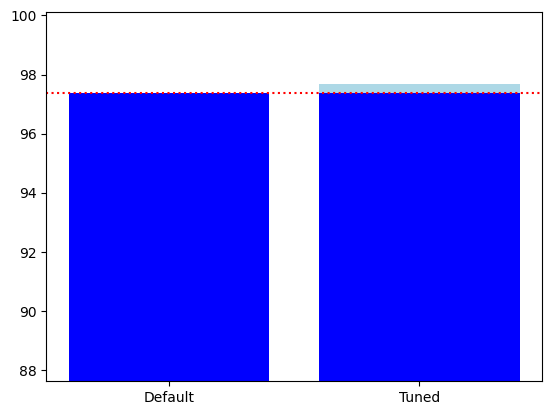

In [53]:

val1=[defaultAccuracy,defaultAccuracy]
plt.bar(["Default","Tuned"],val1,color='blue')
plt.bar(["Default","Tuned"],[0,accuracyTuned-defaultAccuracy],bottom=val1,color='lightblue')
# Add a dotted line
plt.axhline(y=defaultAccuracy, color='red', linestyle='dotted')

plt.ylim(defaultAccuracy-(defaultAccuracy/10),accuracyTuned+(accuracyTuned/40))
plt.show()

